# Fine-Tuning BERT for Multi-Class Text Classification

### Introduction

This notebook demonstrates the process of fine-tuning a pre-trained BERT model (`bert-base-uncased`) for a multi-class text classification task with 27 classes. The workflow covers all essential steps, from dataset preparation to model evaluation, using the Hugging Face Transformers library.

**Key steps in this notebook include:**

1. **Import libraries and Settings**  

2. **Dataset Preparation**  
   - get preprocessed data and load it using the Hugging Face `datasets` library.  
   - Define consistent mappings between string labels and numerical IDs (`label2id` and `id2label`) for training and evaluation.

3. **Tokenizing** 
   - Tokenize the text using the BERT tokenizer and prepare it for model input.  
   - Use a data collator for dynamic padding during training.

3. **Model Setup and Fine-Tuning**  
   - Load a pre-trained BERT model for sequence classification.  
   - Freeze the majority of BERT layers and fine-tune the last two transformer layers along with the pooler and classifier head to optimize performance efficiently.  
   - Implement **Layer-wise Learning Rate Decay (LLRD)** to train different layers at different learning rates, improving stability and convergence.

4. **Training**  
   - Use the Hugging Face `Trainer` API to manage training, evaluation, checkpointing, and early stopping.  
   - Monitor validation metrics and save the best-performing model.

5. **Model Saving and Archiving**  
   - Save the fine-tuned model and tokenizer.  
   - Create a ZIP archive for easy sharing or deployment.

6. **Evaluation**  
   - Generate predictions on the test dataset.  
   - Compute a detailed **classification report** and visualize a normalized **confusion matrix** to analyze per-class performance.

This notebook provides a full, end-to-end workflow for fine-tuning BERT on custom text classification tasks, leveraging advanced techniques such as selective layer unfreezing and LLRD to achieve efficient and effective model training.

In [14]:
# Import Libraries
import pandas as pd
import numpy as np

import torch

from datasets import load_dataset
from datasets import Dataset

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from transformers import BertForSequenceClassification, BertTokenizer
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import EarlyStoppingCallback

from evaluate import load
import os
from pathlib import Path

# Set project root
PROJECT_ROOT = "/Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce"
os.chdir(PROJECT_ROOT)

print("Project root:", PROJECT_ROOT)
print("Working directory:", os.getcwd())

Using device: mps
Project root: /Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce
Working directory: /Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce


### Extracting the Dataset from a ZIP File

This code snippet handles the creation of the dataset and its required structure:

1. Get preprocessed text data
2. Define mappings labels to numerical ID 
3. Split train/val dataset
4. Create dataframe

This ensures that the dataset is available in an accessible folder for further preprocessing and model training.

Mappings are done between the textual class labels and their corresponding numerical IDs. These mappings are essential for text classification tasks because models work with numerical labels internally, while the original data may have string-based class identifiers.

- **`id2label`**: Converts a numerical ID (used by the model) back to its original string label. This is useful when interpreting the model's predictions.  
- **`label2id`**: Converts a string label from the dataset to its corresponding numerical ID. This is used when encoding the dataset before training.

Having consistent `id2label` and `label2id` mappings ensures that the model outputs and evaluation metrics are correctly aligned with the original class labels.

In [23]:
# Load preprocessed data from template pipeline
X_train = pd.read_csv("./src/data/preprocessed/X_train.csv", index_col=0)
y_train = pd.read_csv("./src/data/preprocessed/y_train.csv", index_col=0)
X_test = pd.read_csv("./src/data/preprocessed/X_test.csv", index_col=0)
y_test = pd.read_csv("./src/data/preprocessed/y_test.csv", index_col=0)

# Encode labels to 0-26
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train.values.ravel())
y_test_encoded = le.transform(y_test.values.ravel())

# Create id2label and label2id from the encoder
id2label = {i: str(cat_id) for i, cat_id in enumerate(le.classes_)}
label2id = {str(cat_id): i for i, cat_id in enumerate(le.classes_)}

print("="*50)
print("LABEL MAPPINGS")
print("="*50)
print(f"Total classes: {len(le.classes_)}")
print(f"\nOriginal category IDs (sorted): {le.classes_}")
print(f"\nid2label (first 5): {dict(list(id2label.items())[:5])}")
print(f"label2id (first 5): {dict(list(label2id.items())[:5])}")

# Split train into train/val (80/20)
from sklearn.model_selection import train_test_split
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train_encoded, test_size=0.2, random_state=42, stratify=y_train_encoded
)

# Create dataframe
train_df = pd.DataFrame({"text": X_train_split["text"].values, "labels": y_train_split})
val_df = pd.DataFrame({"text": X_val_split["text"].values, "labels": y_val_split})
test_df = pd.DataFrame({"text": X_test["text"].values, "labels": y_test_encoded})

print(f"Train: {len(train_df)}, Val: {len(val_df)}, Test: {len(test_df)}")

LABEL MAPPINGS
Total classes: 27

Original category IDs (sorted): [  10   40   50   60 1140 1160 1180 1280 1281 1300 1301 1302 1320 1560
 1920 1940 2060 2220 2280 2403 2462 2522 2582 2583 2585 2705 2905]

id2label (first 5): {0: '10', 1: '40', 2: '50', 3: '60', 4: '1140'}
label2id (first 5): {'10': 0, '40': 1, '50': 2, '60': 3, '1140': 4}
Train: 54345, Val: 13587, Test: 16984


### Loading the Dataset, Tokenization, and Preparing the Model

This section covers the steps for loading the dataset, tokenizing the text, and setting up the pre-trained BERT model for sequence classification:

1. **Imports and Device Setup**  
   - Import necessary libraries for dataset handling (`datasets`), model and tokenizer (`transformers`), evaluation (`evaluate`), and tensor operations (`torch`, `numpy`).  
   - Determine the device (`CPU` or `GPU`) for model training.

2. **Loading the Dataset**  
   - Load the preprocessed dataset from disk using `load_from_disk()`.  

3. **Tokenizer Setup and Tokenization**  
   - Load the `bert-base-uncased` tokenizer.  
   - Define `tokenize_function` to tokenize input text, applying truncation and padding to a maximum sequence length of 128.  
   - Use `dataset.map()` to tokenize the entire dataset efficiently in batches.  
   - Initialize `DataCollatorWithPadding` to handle dynamic padding during training.

4. **Model Setup**  
   - Load a pre-trained BERT model for sequence classification with 27 labels and specify `id2label` and `label2id` mappings.  

5. **Layer Freezing and Fine-Tuning**  
   - Freeze all BERT layers initially to prevent updates during training.  
   - Unfreeze the last two transformer layers (`encoder.layer.10` and `encoder.layer.11`) for fine-tuning.  
   - Optionally, unfreeze the pooler and classifier head to allow training on these layers.  

6. **Check Trainable Parameters**  
   - Print the total number of trainable parameters to verify which parts of the model will be updated during training.

This setup allows efficient fine-tuning of the model by training only the most relevant layers while keeping the majority of BERT frozen, reducing memory usage and training time.

In [28]:
import numpy as np

del model
import torch
torch.cuda.empty_cache() if torch.cuda.is_available() else None

#from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
    EarlyStoppingCallback
)
from evaluate import load

from datasets import Dataset

# Convert pandas to HF Dataset
dataset_train = Dataset.from_pandas(train_df)
dataset_val = Dataset.from_pandas(val_df)
dataset_test = Dataset.from_pandas(test_df)

# Combine into DatasetDict
from datasets import DatasetDict
dataset = DatasetDict({
    "train": dataset_train,
    "val": dataset_val,
    "test": dataset_test
})

print(dataset)

#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):

    texts = [
        text if (text is not None and text.strip() != "") else "[EMPTY]"
        for text in examples["text"]
    ]
    
    #return tokenizer(examples["text"],
    return tokenizer(texts,
                     padding="max_length",
                     truncation=True,
                     max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer)

model = AutoModelForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=27,
    id2label=id2label,
    label2id=label2id
)

# Freeze entire BERT
for p in model.bert.parameters():
    p.requires_grad = False

# Unfreeze last two transformer layers
for name, param in model.bert.named_parameters():
    if name.startswith("encoder.layer.10") or name.startswith("encoder.layer.11"):
        param.requires_grad = True

# Unfreeze pooler (optional but recommended)
for name, param in model.bert.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

# Unfreeze classifier head
for p in model.classifier.parameters():
    p.requires_grad = True

print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# 7. Move model to device 
model.to(device)
print(f"Model moved to: {next(model.parameters()).device}")

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 54345
    })
    val: Dataset({
        features: ['text', 'labels'],
        num_rows: 13587
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 16984
    })
})
Using device: mps


Map:   0%|          | 0/54345 [00:00<?, ? examples/s]

Map:   0%|          | 0/13587 [00:00<?, ? examples/s]

Map:   0%|          | 0/16984 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Trainable parameters: 14787099
Model moved to: mps:0


### Setting Up Layer-wise Learning Rate Decay (LLRD) and Trainer

This section prepares the training setup, including metrics, optimizer configuration with Layer-wise Learning Rate Decay (LLRD), and the Hugging Face `Trainer`.

1. **Evaluation Metrics**  
   - Define `compute_metrics()` to calculate **accuracy** during evaluation by comparing predicted labels with ground truth labels.

2. **Layer-wise Learning Rate Decay (LLRD)**  
   - `get_llrd_params()` constructs parameter groups with different learning rates:  
     - **Classifier head**: highest learning rate.  
     - **Pooler**: moderate learning rate.  
     - **Transformer encoder layers**: progressively smaller learning rates from top (last) layer to bottom (first) layer.  
     - **Embeddings**: smallest learning rate.  
   - This approach allows fine-tuning the model more effectively by updating higher layers more aggressively while keeping lower layers stable.

3. **Training Arguments**  
   - `TrainingArguments` specifies training hyperparameters, such as batch size, number of epochs, learning rate, warmup, weight decay, evaluation strategy, mixed precision (`fp16`), and logging.  
   - `load_best_model_at_end=True` ensures the best model according to validation accuracy is kept.

4. **Trainer Initialization**  
   - `Trainer` handles the training loop, evaluation, and checkpointing.  
   - Pass in the model, datasets, tokenizer, data collator, metrics function, and custom optimizer with LLRD parameter groups.  
   - Use `EarlyStoppingCallback` to stop training if validation accuracy does not improve for 5 consecutive evaluation steps.

This setup leverages advanced fine-tuning techniques like LLRD and early stopping to improve performance while optimizing training stability and efficiency.

In [29]:
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
import numpy as np

# -------- Metrics ----------
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": np.mean(preds == labels)}

# --------- LLRD PARAMETER GROUPS ----------
def get_llrd_params(model, base_lr=5e-5):
    # Layer-wise learning rate decay
    lr_factor = 0.85

    opt_params = []
    
    # Classifier head (highest LR)
    opt_params.append({
        "params": model.classifier.parameters(),
        "lr": base_lr * 3.0
    })

    # Pooler (optional)
    opt_params.append({
        "params": model.bert.pooler.parameters(),
        "lr": base_lr
    })

    # Encoder layers: progressively smaller LR
    for layer_idx in range(11, -1, -1):  # layer 11 down → 0
        layer = f"encoder.layer.{layer_idx}."
        params = [p for n, p in model.bert.named_parameters() if n.startswith(layer)]

        if len(params) == 0:
            continue

        layer_lr = base_lr * (lr_factor ** (11 - layer_idx))

        opt_params.append({
            "params": params,
            "lr": layer_lr
        })

    # Embeddings (smallest LR)
    embed_params = list(model.bert.embeddings.parameters())
    opt_params.append({
        "params": embed_params,
        "lr": base_lr * (lr_factor ** 12)
    })

    return opt_params

# --------- Training Arguments ----------
training_args = TrainingArguments(
    output_dir="./birdy-optimized",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=5e-5,             # Base LR (LLRD scales from this)
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    warmup_ratio=0.06,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    fp16=True,                      # Or bf16=True
    report_to="none"
)

optimizer_params = get_llrd_params(model, base_lr=5e-5)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    optimizers=(
        torch.optim.AdamW(
            optimizer_params,
            betas=(0.9, 0.98),
            eps=1e-6,
            weight_decay=0.01
        ),
        None  # HF Trainer will create scheduler automatically
    ),
    callbacks=[
        EarlyStoppingCallback(early_stopping_patience=5)
    ]
)

# Verify trainer device
print(f"Trainer using: {trainer.args.device}")

Trainer using: mps


/var/folders/kk/qqvwrbxs46z729m49q4xyyqm0000gn/T/ipykernel_21862/3540186750.py:74: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [30]:
# ============================================
# Cell: PRE-TRAINING VALIDATION CHECKS
# ============================================

import torch
import numpy as np

train_dataset = tokenized_datasets["train"]
eval_dataset = tokenized_datasets["test"]

print("="*50)
print("DATASET CHECKS")
print("="*50)
print(f"Train size: {len(train_dataset)}")
print(f"Eval size: {len(eval_dataset)}")
print(f"Train columns: {train_dataset.column_names}")
print(f"Sample labels (first 10): {train_dataset['labels'][:10]}")
print(f"Label min: {min(train_dataset['labels'])}")
print(f"Label max: {max(train_dataset['labels'])}")
print(f"Unique labels count: {len(set(train_dataset['labels']))}")

print("\n" + "="*50)
print("MODEL CHECKS")
print("="*50)
print(f"Num labels configured: {model.config.num_labels}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Trainable params: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

print("\n" + "="*50)
print("PREDICTION TEST")
print("="*50)
# Test one batch
sample_batch = train_dataset[:4]
inputs = {
    'input_ids': torch.tensor(sample_batch['input_ids']).to(device),
    'attention_mask': torch.tensor(sample_batch['attention_mask']).to(device)
}
with torch.no_grad():
    outputs = model(**inputs)
    preds = torch.argmax(outputs.logits, dim=1)
    
print(f"Sample predictions: {preds.cpu().tolist()}")
print(f"Sample true labels: {sample_batch['labels'][:4]}")
print(f"Output logits shape: {outputs.logits.shape}")

print("\n" + "="*50)
print("LABEL DISTRIBUTION")
print("="*50)
from collections import Counter
label_counts = Counter(train_dataset['labels'])
print(f"Most common labels: {label_counts.most_common(5)}")
print(f"Least common labels: {label_counts.most_common()[-5:]}")


DATASET CHECKS
Train size: 54345
Eval size: 16984
Train columns: ['text', 'labels', 'input_ids', 'token_type_ids', 'attention_mask']
Sample labels (first 10): [23, 21, 9, 23, 25, 7, 14, 4, 23, 13]
Label min: 0
Label max: 26
Unique labels count: 27

MODEL CHECKS
Num labels configured: 27
Model device: mps:0
Trainable params: 14,787,099

PREDICTION TEST
Sample predictions: [3, 3, 3, 3]
Sample true labels: [23, 21, 9, 23]
Output logits shape: torch.Size([4, 27])

LABEL DISTRIBUTION
Most common labels: [(23, 6533), (13, 3246), (9, 3229), (16, 3195), (21, 3193)]
Least common labels: [(3, 533), (17, 527), (10, 517), (15, 514), (6, 489)]


### Training the Model and Saving the Best Checkpoint

This snippet starts the fine-tuning process and saves the trained model:

1. **Start Training**  
   - `trainer.train()` runs the full training loop using the datasets, optimizer, and training arguments defined earlier.  
   - The Hugging Face `Trainer` handles batching, evaluation, checkpointing, and logging automatically.

2. **Save the Model**  
   - `trainer.save_model("./birdy-optim")` saves the fine-tuned model and tokenizer to the specified directory.  
   - This allows you to reload the trained model later for inference or further fine-tuning.

After this step, the model is fully trained and ready for evaluation or deployment.

In [31]:
trainer.train()
trainer.save_model("./models/bert-rakuten-final")

/Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,1.579600,0.918193,0.725767
2,0.813000,0.724582,0.781997
3,0.650100,0.649891,0.804813
4,0.550000,0.605430,0.820858
5,0.484300,0.595296,0.823508


/Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jennylam/Documents/02 - Wissen/005 - IT/DataScientest_Learn/Rakuten_MLOps_Project/MLOps_classification_e-commerce/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg

### Creating a ZIP Archive of the Trained Model

This snippet compresses the fine-tuned model into a ZIP file for easy storage or sharing:

1. **Model Path**  
   - `path = "./birdy-optim"` points to the directory containing the saved model and tokenizer.

2. **Create ZIP Archive**  
   - `shutil.make_archive(path, 'zip', path)` creates a ZIP file named `birdy-optim.zip` containing all files in the model directory.  

This allows the trained model to be easily uploaded, transferred, or backed up.

In [32]:

# Save label mapping
import json
with open("./models/bert-rakuten-final/id2label.json", "w") as f:
    json.dump(id2label, f)

print("✅ Model saved to ./models/bert-rakuten-final/")

✅ Model saved to ./models/bert-rakuten-final/


### Evaluation: Classification Report and Confusion Matrix

This section defines helper functions to evaluate and visualize the model's performance:

1. **Load Label Mapping**  
   - `load_id2label()` loads the `id2label` mapping from a JSON file.  
   - `id2_label()` converts a numeric class ID into its corresponding string label.

2. **Display Metrics and Confusion Matrix**  
   - `display_cm(labels, predicted_classes)` prints the **classification report** (precision, recall, F1-score, support) using `sklearn.metrics.classification_report`.  
   - Computes the **normalized confusion matrix** to show how predictions compare to true labels.  
   - Uses `seaborn` to create a heatmap of the confusion matrix for easy visualization, with class labels on both axes.  
   - Normalization and rounding make the matrix easier to interpret.

These functions allow a detailed analysis of the model’s predictions across all classes, helping identify strengths and weaknesses in classification performance.

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json

# ---------------------------------------------------------
# DISPLAY FUNCTION FROM YOU
# ---------------------------------------------------------
# def load_id2label(file_path="./id2label"):

#     with open(file_path, "r", encoding="utf-8") as f:
#         id2_label = json.load(f)
#         return id2_label

# def id2_label(id2_label, id):
#     return id2_label[id]

# def display_cm(labels, predicted_classes):

#     id2_label = load_id2label()
#     ticks = []
#     for i in range(27):
#         ticks.append(id2_label[str(i)])
    
#     class_report = classification_report(labels, predicted_classes)
#     print("Classification Report:\n", class_report)

#     print("\nConfusion Matrix:")
#     cm = confusion_matrix(labels, predicted_classes, normalize='true')

#     cm_display = np.round(cm, 2)

#     plt.figure(figsize=(20, 10))
#     sns.heatmap(cm_display, annot=True, fmt='.2f', cmap='viridis', xticklabels=ticks, yticklabels=ticks)
#     plt.title("Confusion Matrix")
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.tight_layout()
#     plt.show()

def display_cm(labels, predicted_classes, id2label):
    ticks = [id2label[i] for i in range(27)]
    
    class_report = classification_report(labels, predicted_classes, target_names=ticks)
    print("Classification Report:\n", class_report)
    
    cm = confusion_matrix(labels, predicted_classes, normalize='true')
    cm_display = np.round(cm, 2)
    
    plt.figure(figsize=(20, 10))
    sns.heatmap(cm_display, annot=True, fmt='.2f', cmap='viridis', 
                xticklabels=ticks, yticklabels=ticks)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

### Generating Predictions from a Fine-Tuned BERT Model

This section demonstrates how to load a fine-tuned BERT checkpoint and generate predictions on a dataset:

1. **Load Model and Tokenizer**  
   - `AutoModelForSequenceClassification.from_pretrained(checkpoint_path)` loads the saved checkpoint of the fine-tuned model.  
   - `AutoTokenizer.from_pretrained(checkpoint_path)` ensures consistent tokenization.  
   - Move the model to the appropriate device (`CPU` or `GPU`) and set it to evaluation mode with `model.eval()`.

2. **Prediction Function**  
   - `get_predictions(model, dataloader, device)` iterates over a dataloader and computes predictions without updating model weights (`torch.no_grad()`).  
   - Extracts `input_ids` and `attention_mask` from the batch and optionally handles other modalities like `images`.  
   - Computes logits via the model and selects the predicted class using `torch.argmax`.  
   - Collects all true labels and predicted classes into NumPy arrays for evaluation.

This function provides a ready-to-use way to obtain predictions for computing metrics like accuracy, F1-score, and confusion matrices on any dataset.

In [36]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Example for a BERT classifier
#checkpoint_path = "./birdy-optimized/checkpoint-12576"  # replace with your actual checkpoint folder
checkpoint_path = "./models/bert-rakuten-final"

model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

model.to(device)
model.eval()

import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions

def get_predictions(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            images = batch['images'].to(device) if 'images' in batch else None

            # Forward pass
            if images is not None:
                logits = model(input_ids, attention_mask, images)
            else:
                # For HF models, access the logits
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

            preds = torch.argmax(logits, dim=-1)

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    labels = np.concatenate(all_labels)
    predicted_classes = np.concatenate(all_preds)
    return labels, predicted_classes

### Evaluating the Model on the Test Set

This snippet sets up a DataLoader for the test dataset, generates predictions, and visualizes the results:

1. **Test DataLoader**  
   - `DataLoader` is used to create batches from the tokenized test dataset.  
   - `default_data_collator` ensures each batch is returned as a dictionary of tensors, compatible with the model.

2. **Generate Predictions**  
   - `get_predictions(model, test_loader, device)` runs the model on the test set and collects true labels and predicted classes.

3. **Display Metrics and Confusion Matrix**  
   - `display_cm(labels, predicted_classes)` prints a detailed classification report and shows a normalized confusion matrix using a heatmap for easy visualization.  

This allows a complete evaluation of the fine-tuned model on unseen data, helping identify class-wise performance and potential areas for improvement.

Classification Report:
               precision    recall  f1-score   support

          10       0.67      0.60      0.63       623
          40       0.74      0.75      0.75       502
          50       0.81      0.75      0.78       336
          60       0.93      0.87      0.90       166
        1140       0.74      0.79      0.76       534
        1160       0.92      0.95      0.94       791
        1180       0.67      0.50      0.57       153
        1280       0.75      0.69      0.72       974
        1281       0.61      0.57      0.59       414
        1300       0.91      0.96      0.94      1009
        1301       0.93      0.83      0.88       161
        1302       0.79      0.70      0.74       498
        1320       0.74      0.72      0.73       648
        1560       0.82      0.78      0.80      1015
        1920       0.86      0.92      0.89       861
        1940       0.80      0.91      0.85       161
        2060       0.78      0.76      0.77       999
   

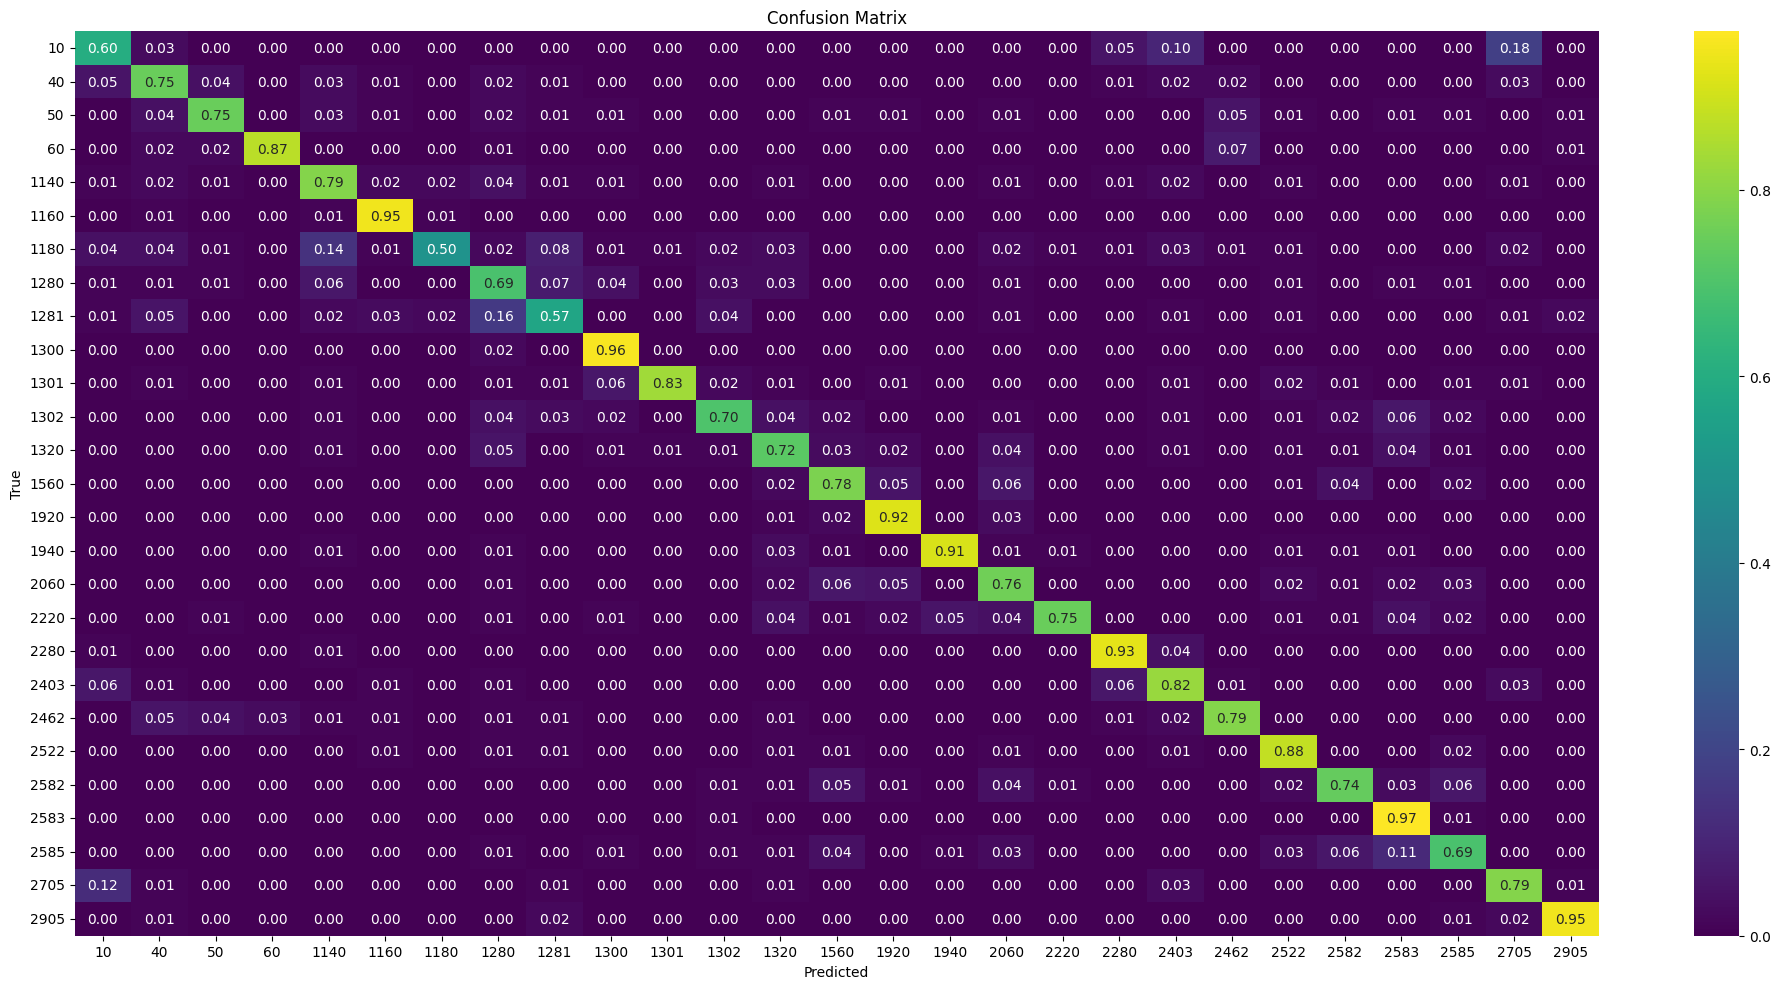

In [37]:
from torch.utils.data import DataLoader
from transformers import default_data_collator

test_loader = DataLoader(
    tokenized_datasets["test"],
    batch_size=16,
    collate_fn=default_data_collator  # important to get batch as dict of tensors
)

labels, predicted_classes = get_predictions(model, test_loader, device)
#display_cm(labels, predicted_classes)
display_cm(labels, predicted_classes, id2label)

In [38]:
# Create pickle label encoder for further purposes

from sklearn.preprocessing import LabelEncoder
import pickle
import json
import numpy as np

# Load your id2label.json (or recreate from model config)
model = AutoModelForSequenceClassification.from_pretrained("./models/bert-rakuten-final")
id2label = model.config.id2label

# Recreate LabelEncoder
le = LabelEncoder()
le.classes_ = np.array([int(id2label[i]) for i in range(len(id2label))])

# Save
with open("./models/bert-rakuten-final/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print("✅ Label encoder created and saved!")
print(f"Classes: {le.classes_}")

✅ Label encoder created and saved!
Classes: [  10   40   50   60 1140 1160 1180 1280 1281 1300 1301 1302 1320 1560
 1920 1940 2060 2220 2280 2403 2462 2522 2582 2583 2585 2705 2905]


In [39]:
tokenized_datasets["test"].save_to_disk("./src/data/processed/test_dataset")

Saving the dataset (0/1 shards):   0%|          | 0/16984 [00:00<?, ? examples/s]